In [311]:
import pandas as pd            
import numpy as np             
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [405]:
# Read csv
df = pd.read_csv('CrowdstormingDataJuly1st.csv')
# Drop meaningless columns, we don't need the whole player name nor the birthday
df.drop(['player','birthday'], 1, inplace=True)
# Drop dyads where there are no photoID
df.dropna(axis=0, subset=['photoID'], inplace=True)
df.drop('photoID', 1, inplace=True)
# Drop dyads where there are no rating
df.dropna(axis=0, how='all', subset=['rater1', 'rater2'], inplace=True)

In [406]:
# First, try without 'racist data'
df.drop(['refNum','refCountry','Alpha_3','meanIAT','nIAT','seIAT','meanExp','nExp','seExp'], 1, inplace=True)

In [474]:
# Need to sum for the aggregation
sumAggIndexes = ['playerShort', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards','yellowReds', 'redCards']
dfSumAgg = df[sumAggIndexes]
aggregatedWithSum = dfSumAgg.groupby('playerShort').sum()

# No sum for aggregation
dfIdentityAgg = df[['playerShort', 'club', 'leagueCountry', 'height', 'weight',
       'position', 'rater1', 'rater2']]
identity = lambda x: x.iloc[0]
aggregatedWithIdentity = dfIdentityAgg.groupby('playerShort').agg(identity)

# Concatenate
dfd = pd.concat([aggregatedWithIdentity, aggregatedWithSum], axis=1)


In [475]:
# Normalize:

# vitories, defeats, ties, goals, cards -> 
#   for each player x: x._/x.games

colsToNorm = ['victories', 'ties', 'defeats', 'goals', 'yellowCards','yellowReds', 'redCards']
ds = []
for c in colsToNorm:
    col = []
    for i in dfd.index:
        col.append(dfd[c].loc[i]/dfd['games'].loc[i])
    ds.append(pd.DataFrame(columns=[c], index=dfx.index, data=col))
 
# Normalize the games column
colsToNorm.append('games')
meanGames = dfd['games'].mean()
stdGames = dfd['games'].std()

ds.append(pd.DataFrame(columns=['games'], index=dfd.index, data=dfd['games'].map(lambda x : (x-meanGames)/stdGames)))

dfd = pd.concat([pd.concat(ds,axis=1), dfd.drop(colsToNorm, axis=1)] ,axis=1)

In [462]:
# Deal with NaN in weight and height
# There are only few missing data so we can fill them with the mean of the column without
# inducing to much bias in the data

ws = dfd['weight']
meanW = ws.dropna().mean()
dfd['weight'].fillna(meanW, inplace=True)

hs = dfd['height']
meanH = hs.dropna().mean()
dfd['height'].fillna(meanH, inplace=True)

In [463]:
# skin color
colors = np.array([0, 0.25, 0.5, 0.75, 1])
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

meanColor = (dfd['rater1']+dfd['rater2'])/2

# This is the target/observation
target = meanColor.apply(lambda x: find_nearest(colors, x)).astype('str')
# This is the data
data = dfd.drop(['rater1', 'rater2'], axis=1)
data.head()

,goals,yellowCards,yellowReds,redCards,games,club,leagueCountry,height,weight,position
playerShort,,,,,,,,,,
aaron-hughes,0.013761,0.029052,0.000000,0.000000,2.935828,Fulham FC,England,182.0,71.0,Center Back
aaron-hunt,0.184524,0.125000,0.000000,0.002976,0.705694,Werder Bremen,Germany,183.0,73.0,Attacking Midfielder
aaron-lennon,0.075243,0.026699,0.000000,0.000000,1.238682,Tottenham Hotspur,England,165.0,63.0,Right Midfielder
aaron-ramsey,0.150000,0.119231,0.000000,0.003846,0.172706,Arsenal FC,England,178.0,76.0,Center Midfielder
abdelhamid-el-kaoutari,0.008065,0.064516,0.032258,0.016129,-0.781062,Montpellier HSC,France,180.0,73.0,Center Back


In [464]:
# Encode the categorical features
le = preprocessing.LabelEncoder()
clubEncoded = pd.Series(index=data.index, data=le.fit_transform(data.club))
leagueCountryEncoded = pd.Series(index=data.index, data=le.fit_transform(data.leagueCountry))
# Encode the 'position', it has NaN values, so we handle them by replacing them
# by the most frequent label
position = data['position']
posFiltered = position.dropna()
posNan = position[position.isnull()]
posFilEnc = le.fit_transform(posFiltered)
posFilEncAsSerie = pd.Series(index=posFiltered.index, data=posFilEnc)
concat = pd.concat([posFilEncAsSerie, posNan])
positionWithNan = concat.sort_index()

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=1)
positionEncoded = pd.Series(index=positionWithNan.index, data=imp.fit_transform(positionWithNan)[0].astype(int))

# Dataframe with categorical data encoded as int
dataEncoded = pd.concat([clubEncoded, positionEncoded, leagueCountryEncoded],axis=1)
dataEncoded.columns = ['club', 'position', 'leagueCountry']

C:\Users\bapti\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [465]:
# One hot encoder
enc = preprocessing.OneHotEncoder()
enc.fit(dataEncoded)
oneHotEncodedData = enc.transform(dataEncoded).toarray()
#oneHotEncodedData.astype()
dfEncoded = pd.DataFrame(index=dataEncoded.index, data=oneHotEncodedData).astype(int)

In [466]:
# New data with categorical data encoded
dff = pd.concat([data.drop(['club','position','leagueCountry'], axis=1), dfEncoded], axis=1)

In [467]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(dff, target, test_size=0.3, random_state=0)

In [479]:
# Classifier
clf = RandomForestClassifier(n_jobs=-1)

In [480]:
cross_val_score(clf, dff, target).mean()

0.42333882147285401

(array([ 20.,  16.,  11.,  18.,  12.,   4.,   5.,   6.,   4.,   2.,   4.,
          0.,   1.,   1.,   1.,   1.,   2.,   1.,   2.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          1.,   1.]),
 array([ 0.        ,  0.00063765,  0.00127531,  0.00191296,  0.00255062,
         0.00318827,  0.00382592,  0.00446358,  0.00510123,  0.00573889,
         0.0063765

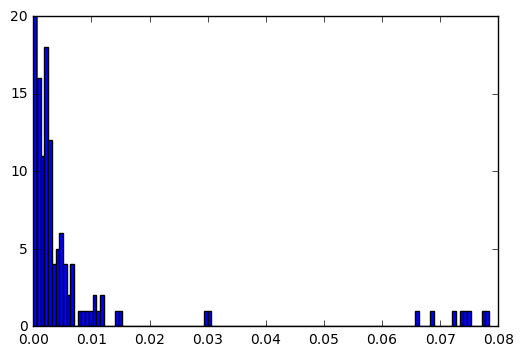

In [487]:
clf.fit(X_train,y_train)
plt.hist(clf.feature_importances_, bins=len(X_train.columns))


# TEST CELLS

In [471]:


d = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
                  'foo', 'bar', 'foo', 'foo'],
                  'B' : ['one', 'one', 'two', 'three',
                          'two', 'two', 'one', 'three'],
                  'C' : np.random.randn(8),
                  'D' : np.random.randn(8),
                  'E' : [np.nan,'0','1','0','1','0','1','1'],
                  'F' : [1,2,3,4,5,6,7,8]})
d.set_index('F', inplace=True)

In [472]:
x = []
for c in d['A']:
    x.append(c)
    
x

['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo']